<a href="https://colab.research.google.com/github/sadVries/PRA3024/blob/main/CNN_PRA3024_Sjoerd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
rm -rf

In [ ]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

Importing early stopping and other stuffero

In [ ]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)


2024-03-18 10:33:03.765636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 10:33:03.765751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 10:33:04.037754: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


I removed the divide by 255 from the data so i have more insight in what is happening when i did my augmentation

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


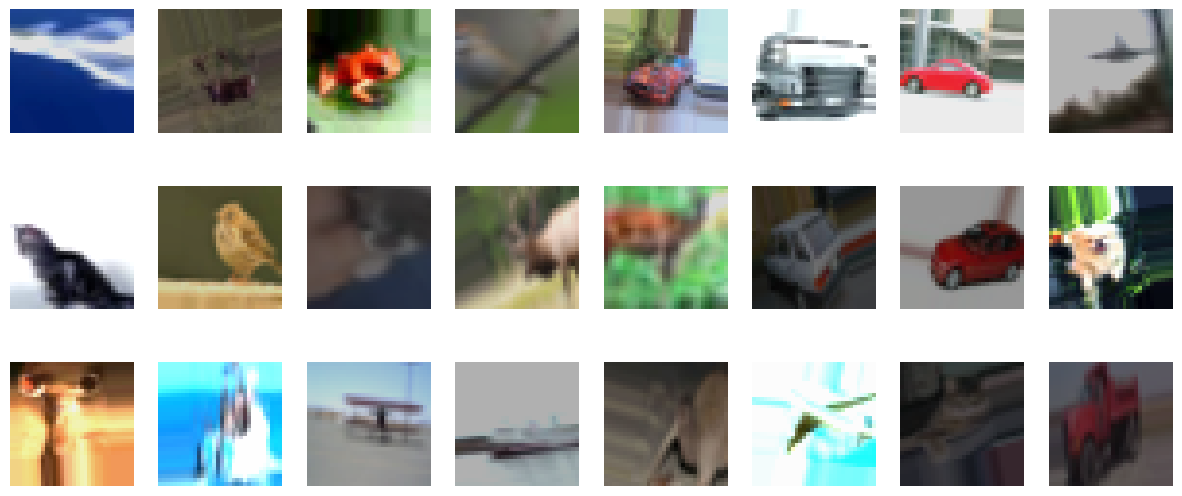

In [ ]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)
#imageDataGen = ImageDataGenerator(brightness_range=)
#print(x_train[0])
datagen = keras.preprocessing.image.ImageDataGenerator(# i could not figure out how this worked within the model i think it is outdated anyway when i read documentation
    #rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    zoom_range=[0.5,1.5],
    brightness_range=(.2,1.6)
    )

datagen.fit(x_train)
fig = plt.figure(figsize=(2 * 8 - 1, 2.5 * 3 - 1))
for X_batch, y_batch in datagen.flow(x_train*255,y_train, batch_size=24):
    for i in range(0, 24):
        #print(X_batch[i])
        plt.subplot(3,8,i+1)
        plt.imshow((X_batch[i]).astype('int32'))
        plt.axis('off')
    break
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

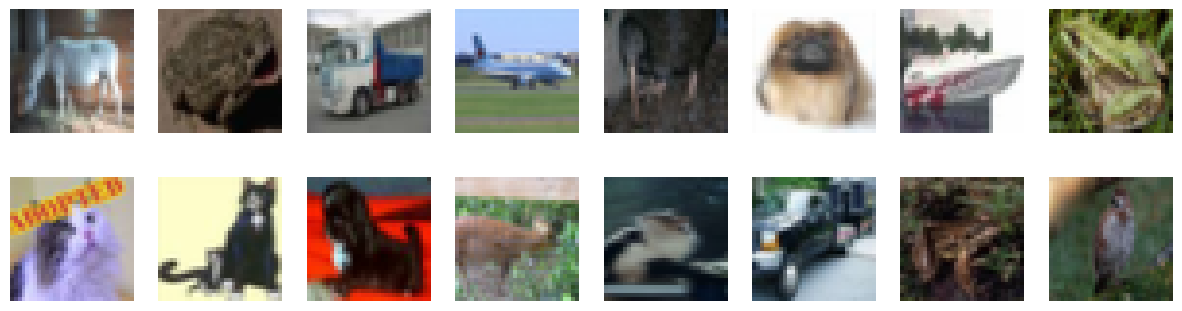

In [ ]:
# show some random images from train, and their labels

#datagen.fit(x_train, augment = True)
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :]/256)
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [ ]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

When testing i did not use the `/255`, but after i knew how to use it i used it to make sure everthing was compressed and `imshow`able

In [ ]:
x_train= x_train/255.
x_val = x_val/255.
x_test = x_test/255.

In [ ]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, LeakyReLU
from keras import layers
from keras.callbacks import EarlyStopping

#from keras.layers.advanced_activations import LeakyReLU
import cv2

Do all the random augmentation with a certain seed for reproducability

(40000, 32, 32, 3)
(40000, 32, 32, 3)


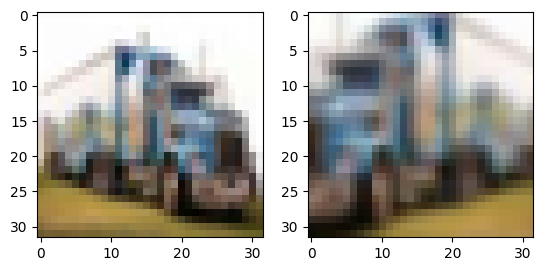

In [ ]:
keras.utils.set_random_seed(812)

ds_random_flip = tf.image.random_flip_left_right(x_train)
ds_random_contrast = tf.image.random_contrast(x_train, .2, .8)
ds_random_hue = tf.image.random_hue(x_train, .5)
ds_random_zoom = tf.image.resize(tf.image.random_crop(x_train, size= (40000,25,25,3)), size=(32,32))

print(ds_random_flip.shape)
print(ds_random_zoom.shape)
plt.subplot(1,2,1)
plt.imshow(ds_random_flip[20000])
plt.subplot(1,2,2)
plt.imshow(ds_random_zoom[20000])
#print(bright[14][0])
#print(x_train[14][0])

Add all the test data and original dataset together and print both shapes to see if they are compatible for `model.fit`

In [ ]:
test = np.concatenate((x_train, ds_random_zoom, ds_random_hue, ds_random_contrast, ds_random_flip),axis =0 )#bright,bright1, bright2,
test2 = np.concatenate((y_train, y_train, y_train, y_train, y_train),axis =0 )#y_train, y_train,y_train,
print(test2.shape)
print(test.shape)

(200000, 10)
(200000, 32, 32, 3)


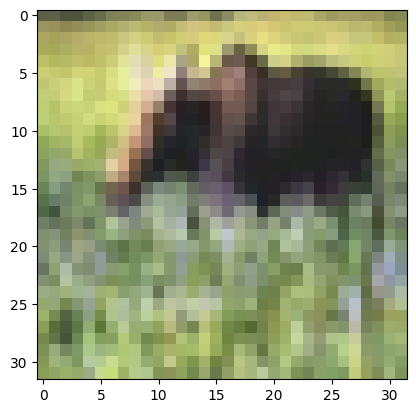

In [ ]:
plt.imshow(test[3])

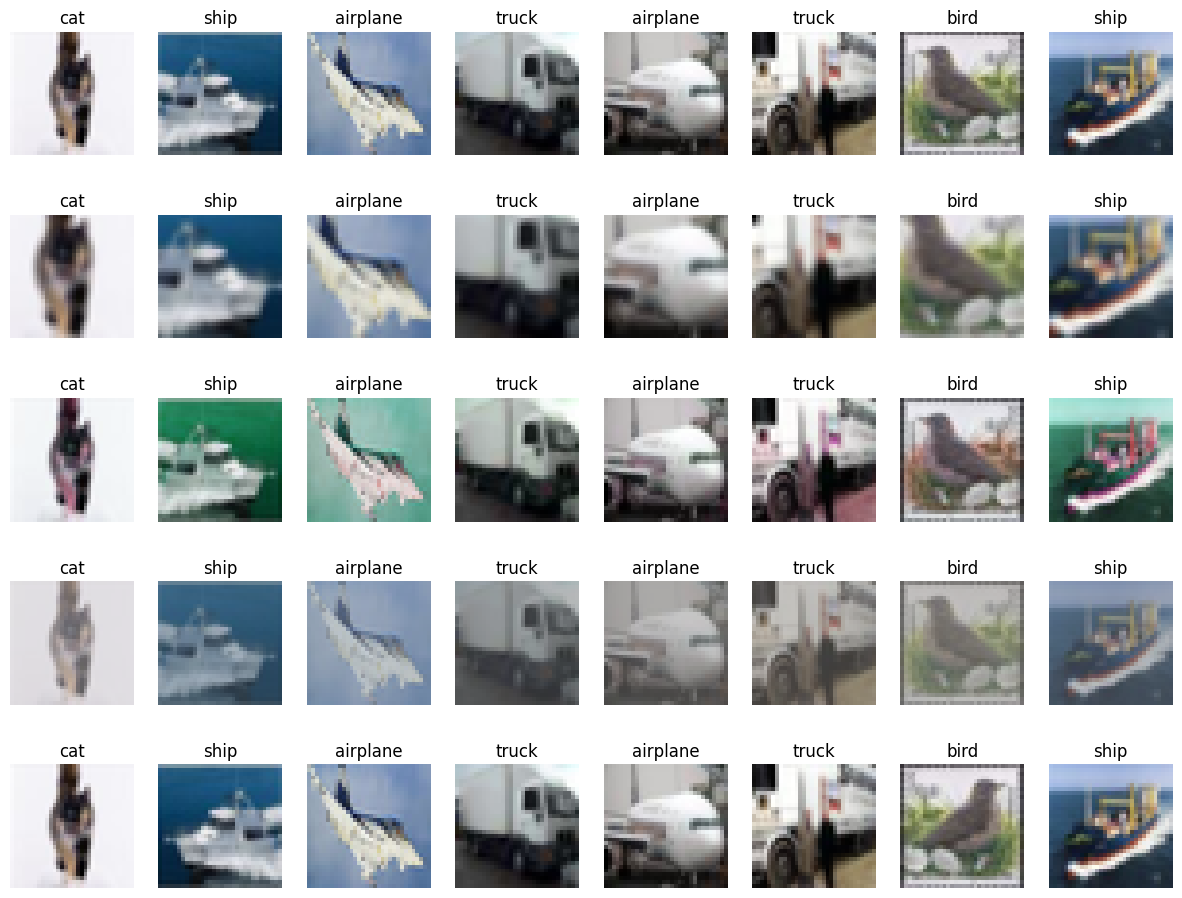

[16, 17, 18, 19, 20, 21, 22, 23, 40016, 40017, 40018, 40019, 40020, 40021, 40022, 40023, 80016, 80017, 80018, 80019, 80020, 80021, 80022, 80023, 120016, 120017, 120018, 120019, 120020, 120021, 120022, 120023, 160016, 160017, 160018, 160019, 160020, 160021, 160022, 160023]


In [ ]:
cols = 8
rows = 5
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
b =16
array= [] # array for testing
for i in range(0, cols, 1):
    for j in range(0,rows,1):
        if b%8 ==0 and b != 16:
            b+=40000-8

        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        #print(random_index)
        #print(i * rows + j + 1)
        ax.set_title(cifar10_classes[np.argmax(test2[b])])
        ax.imshow(test[b, :])
        array += [b]
        b +=1
plt.show()
print(array)

# Models

In [ ]:
def make_model(rate ):
  """
  Define your model architecture here.
  Returns `Sequential` model.
  """
  model = Sequential()

    ### STUDENT CODE HERE ###
    ### --> Build your convolutional neural network.
    ### First, make a CNN layer with some small kernels to learn some basic features, with Conv2D.
  model.add(Conv2D(filters=2, kernel_size = kernel, padding = 'same', input_shape=(32, 32, 3,)  ))

    ### Then, add a Pooling layer to pick up the relevant kernels.
  #model.add(MaxPooling2D(pool_size=(2,2), strides=None, padding='valid',))
  #model.add(Conv2D(filters=2, kernel_size = 3, padding ='same', input_shape=(32, 32, 3,)  ))

    ### Then, add a Pooling layer to pick up the relevant kernels.
  model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid',))
    ### Then, Flatten it and add some fully-connected (Dense) normal NN layers,
  model.add(Flatten())
  model.add(Dense(64, activation='relu' ))
  model.add(Dense(64, activation='sigmoid' ))
    ###  to learn the relevant combinations of low-level kernel features.
    ### Finally, some regularisation is advised, using a Dropout layer, to avoid local minima.
  model.add(Dropout(rate))

  model.add(Dense(10, Activation("softmax")))
    ### Make sure the output is of the same shape as the number of labels we have,
    ### And the input is the same as the figures (which now have a 3rd dimension - color!)
    ### Again, use google to find information on these classes.
    ### END STUDENT CODE ###

    # Ensure normalized probabilities over the 10 classes
  print(model.output_shape)
  model.summary()
  return model

In [ ]:
  def make_model2(rate ):
    model = Sequential()
    model.add(Conv2D(32, (3, 3),  activation = 'relu',padding='same', input_shape = (32, 32, 3,)))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    model.add(layers.BatchNormalization())
    #model.add(Conv2D(32, (3, 3), activation='LeakyReLU'))
    model.add(MaxPooling2D(2,2))

    model.add(Flatten())
    model.add(Dropout(rate))
    model.add(Dense(64, activation='LeakyReLU'))
    model.add(Dense(32, activation='linear'))

    model.add(Dropout(rate))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    return model

In [ ]:
def make_model3(rate ):
  model = Sequential()
  inputs = keras.Input(shape = (32, 32, 3,))
  model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D((2, 2),padding='same'))
  model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

  model.add(Flatten())
  model.add(Dense(128, activation='linear'))
  model.add(LeakyReLU(alpha=0.1))
  model.add(Dense(10, activation='softmax'))
  model.add(Dense(10, activation='softmax'))
  model.summary()
  return model

In [ ]:
def make_model4(rate ):
  model = Sequential()
  #layers.Rescaling(1./255)
  inputs = keras.Input(shape = (32, 32, 3,))
  #model.add(data_augmentation)
  model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same'))
  model.add(layers.GaussianNoise(.3))
  for size in[256,128,64,32]:

    model.add(layers.SeparableConv2D(size, (3, 3),  activation = 'relu',padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.SeparableConv2D(size, (3, 3), activation='gelu',padding='same'))
    model.add(layers.BatchNormalization())
    model.add(Dropout(rate))
    model.add(layers.SeparableConv2D(size, (3, 3), activation='relu',padding='same'))
    model.add(layers.BatchNormalization())
    #model.add(Conv2D(32, (3, 3), activation='LeakyReLU'))
    model.add(MaxPooling2D(3, strides=2, padding="same"))

  model.add(Flatten())
  model.add(Dropout(rate))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='linear'))
  model.add(Dropout(rate))
  model.add(Dense(10, activation='softmax'))
  model.summary()
  return model

In [ ]:
def make_model6(rate ):
  model = Sequential()
  inputs = keras.Input(shape = (32, 32, 3,))
  #model.add(data_augmentation)
  model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same'))
  for size in[256]:#,128,64,32]:

    model.add(layers.SeparableConv2D(size, (3, 3),  activation = 'leaky_relu',padding='same'))
    model.add(layers.BatchNormalization())
    model.add(Dropout(rate/3))
    model.add(layers.SeparableConv2D(size, (3, 3), activation='leaky_relu',padding='same'))
    model.add(layers.BatchNormalization())
    model.add(Dropout(rate/3))
    model.add(layers.SeparableConv2D(size, (3, 3), activation='relu',padding='same'))
    model.add(layers.BatchNormalization())
    #model.add(Conv2D(32, (3, 3), activation='LeakyReLU'))
    model.add(MaxPooling2D(3, strides=2, padding="same"))

  model.add(Flatten())
  model.add(Dropout(rate))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='linear'))
  model.add(Dropout(rate))
  model.add(Dense(10, activation='softmax'))
  model.summary()
  return model

# Train

### Training and fiting

In [ ]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR = 2e-3  # initial learning rate
BATCH_SIZE = 128
EPOCHS = 100
DROPOUT = .7

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
#model = make_model5()
model = make_model4(DROPOUT )  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss=keras.losses.categorical_crossentropy,  # we train 10-way classification
    optimizer=keras.optimizers.Adam(),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)
#datagen.fit(test)
#datagen2.fit(x_val)
# fit model
model.fit(
    test, test2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    #shuffle=True,
    callbacks=[early_stopping]

)

# save weights to file to avoid re-training
#model.save_weights(".weights.h5")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ ?                      │   0 (unbuilt) │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ ?                      │   0 (unbuilt) │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ ?                      │   0 (unbuilt) │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ ?                      │   0 (unbuilt) │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ ?                      │   0 (unbuilt) │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ ?                      │   0 (unbuilt) │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ ?                      │   0 (unbuilt

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 182s 100ms/step - accuracy: 0.1026 - loss: 3.0579 - val_accuracy: 0.0966 - val_loss: 2.3030
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 139s 89ms/step - accuracy: 0.1003 - loss: 2.3038 - val_accuracy: 0.0967 - val_loss: 2.3032
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 89ms/step - accuracy: 0.1002 - loss: 2.3032 - val_accuracy: 0.0967 - val_loss: 2.3029
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 139s 89ms/step - accuracy: 0.1633 - loss: 2.1448 - val_accuracy: 0.1945 - val_loss: 1.9430
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - accuracy: 0.2000 - loss: 1.9218 - val_accuracy: 0.2042 - val_loss: 2.5496
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 139s 89ms/step - accuracy: 0.2885 - loss: 1.7619 - val_accuracy: 0.3436 - val_loss: 1.6482
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 89ms/step - accuracy: 0.4042 - loss: 1.5423 - val_accuracy: 0.5063 - val_loss: 1.3356
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 138s 88ms/step - a

KeyboardInterrupt: 

In [ ]:
model.save_weights(".weights.h5")

### Analyse our CNN

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step


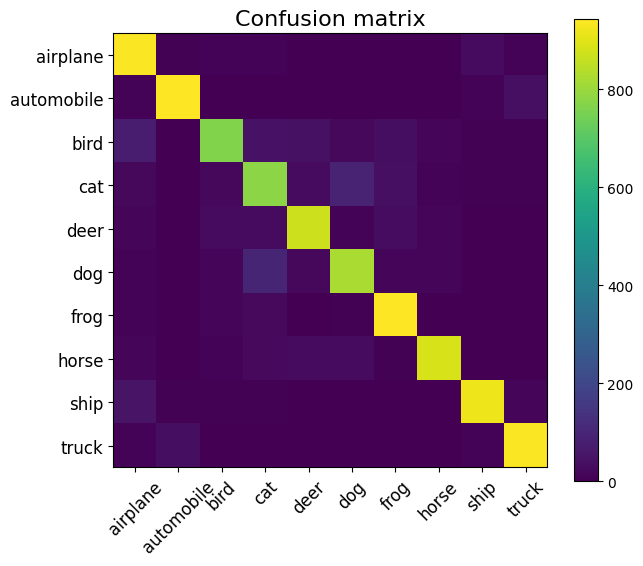

Test accuracy: 0.8804


In [ ]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

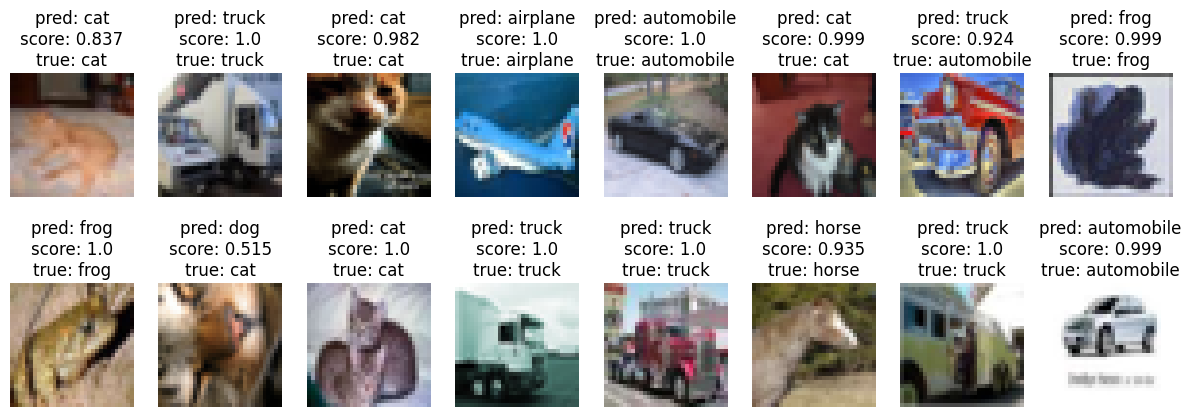

In [ ]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Further Comments and explaining what i did and tried

## Models
First started experimenting with Models.
* I found using alot of pooling got me higher validation accuracy so i used a for loop to make the code more concise
* Adding of Dropout further prevented overtraining and got me more accuracy in the higher ends, got me from 70 tot 80
* I used the Adam optimizer which is commenly used for image classification and helped me not worry about learning rate as it does it automatically
* Last i implemented early stopping so i could run a model and do something else meanwhile
* I kept most of the models i made so it would be easy to go back

## Data augmentation
This was a pain in the buttocks to figure out.
I could not for the life of me figure out how to use ```datagen.fit()```
It was unclear from Stack overflow and all the keras notations, its seems i do not get how it transforms the data.
Even with `augment = True` I think it is impossible to print it to see what is happening, or at least for me at this moment
Eventually i did it using `tf.image` functions and just adding it to the dataset
I feel like it dit not make such a difference this way only that i got 200k images which slowed down training significantly
*
*

## further notes
I used kaggle for training as it has 30hours of TPU/CPU acceleration maybe a hint for next year for this part of the course

### val loss
I noticed that my val_los function sometimes went up althoug val_accuracy went up.
I dug further into this and what happens is that the network is certain that it is another Image label.
looking at the data this might be logical.
Some automobiles definitely looked just like a truck, i mean some trucks(pickups) are both. Some pictures of dogs and cats were almost just fur and there were some images i saw that i was not even to identify myself so a 88% accuracy is kinda okay. As the difference between 82 percent and 88 is kinda use going from 18% error to 12% meant it removed error by a third so i decided to show the latter network.

### lasagne layers
I decided not to look deeper into lasagne layers as learning a new worklflow woulf probably take alot of time and i wanted to get the basics down.

### workflow
My faster network to reach 80 percent was in 9 epoch that took 38 sec each with the augmented data but it overtrained really fast and got stuck at like 81 82 ish percent, this might also be due to a low Dropout rate.
With my remaining GPU time i created this massive network you see now to see how far it would get.
I got an 88% after running tweaking it twice.

The thing i noticed made the most change and got me past the 70% mark were Adding `Dropout` in combination with `SeparableConv2D` and `BatchNormilazation`

all in all it was pretty fun to work on although time consuming since the multiple versions of Keras making some functions 'Legacy' which meant documentation was not always there and some functions were not compatable.

If i had more time i would have tried to import some pretrained models for Image Classification and made some more of my own.
I did not really use any online resources with the exception of stackoverflow explanations and Keras/Tensorflow documentation.

all in all it was alot of fun eventhough it was kinda timeconsuming

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__ Check
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -Check
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


